In [1]:
from __future__ import print_function
from platform import python_version
print(python_version())

import os
from os.path import isfile

import numpy as np
import pickle
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
torch.manual_seed(111)

from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
import keras
import keras.backend.tensorflow_backend as tfback
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Reshape

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

3.7.7


Using TensorFlow backend.


In [2]:
with open('/Users/gollum/Downloads/root_test_data.pkl', 'rb') as rootdata:
    sig1 = pickle.load(rootdata) 
    sig2 = pickle.load(rootdata) 
    bkg1 = pickle.load(rootdata) 
    bkg2 = pickle.load(rootdata)

In [3]:
all_data_sig1 = [np.array(sig1[i][0]).reshape(32,32) for i in range(sig1.shape[0])]
all_data_sig2 = [np.array(sig2[i][0]).reshape(32,32) for i in range(sig2.shape[0])]
# all_data_sig = [np.array(sig[i][0]).reshape(32,32) for i in range(sig.shape[0])]


print(len(all_data_sig1))
print(len(all_data_sig2))

all_data_bkg1 = [np.array(bkg1[i][0]).reshape(32,32) for i in range(bkg1.shape[0])]
all_data_bkg2 = [np.array(bkg2[i][0]).reshape(32,32) for i in range(bkg2.shape[0])]
# all_data_bkg = [np.array(bkg[i][0]).reshape(32,32) for i in range(bkg.shape[0])]

print(len(all_data_bkg1))
print(len(all_data_bkg2))

#### Validating the signal1 & background1 are just a subset of signal2 and background2 ####
counter = 0
for i in range(8085):
    if np.allclose(all_data_sig1[i], all_data_sig2[i]):
        counter += 1

print("Subset Tree:", counter)

8085
10000
8085
10000
Subset Tree: 8085


Example Image Signal Class


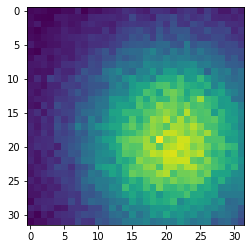

In [4]:
print("Example Image Signal Class")
plt.imshow(all_data_sig2[0])

Example Image Background Class


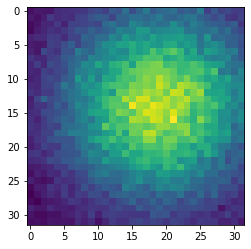

In [5]:
print("Example Image Background Class")
plt.imshow(all_data_bkg2[0])

In [6]:
print("Number Of Images Background Class: ", len(all_data_bkg2))
print("Number Of Images Background Class: ", len(all_data_sig2))

Number Of Images Background Class:  10000
Number Of Images Background Class:  10000


# PyTorch

## Dataloader

In [7]:
sig2_tensor = torch.from_numpy(np.array(all_data_sig2))
bkg2_tensor = torch.from_numpy(np.array(all_data_bkg2))

sig2_labels = torch.zeros(10000,1 , dtype=torch.float32)
bkg2_labels = torch.ones(10000,1, dtype=torch.float32)

data = np.stack((sig2_tensor, bkg2_tensor)).reshape(20000, 1, 32, 32)
target_data = np.stack((sig2_labels, bkg2_labels)).reshape(20000,1)

X_train, X_test, y_train, y_test = train_test_split(
    data, target_data, test_size=0.20, random_state=111)


class TMVADataset(Dataset):
  """TMVA Dataset"""
  def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y

  def __len__(self):
        'Denotes the total number of samples'
        return self.X.size(0)

  def __getitem__(self, index):
        'Generates one sample of data'
        return self.X[index], self.y[index]


train_data = TMVADataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TMVADataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256)

print("Train Set: ", len(train_loader.dataset))
print("Test Set: ", len(test_loader.dataset))

Train Set:  16000
Test Set:  4000


## Model Definition

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16 * 5 * 5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 1)
        self.act   = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        out = self.act(x)
        return out


net_root = Net()

optimizer = optim.Adam(net_root.parameters(), lr=0.001)
criterion = nn.BCELoss()

num_epochs = 10

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

params = count_parameters(net_root)
print("Total Number of parameters in PyTorch Model:", params)

Total Number of parameters in PyTorch Model: 60941


## Training

In [9]:
"""Train and evaluate a model with CPU"""
start = time.time()
for epoch in range(num_epochs):
    running_loss = 0
    for i, data in enumerate(train_loader):
        net_root.train()
        X, y = data
        optimizer.zero_grad()
        y_hat = net_root(X)
        loss = criterion(y_hat, y.float())
        running_loss += loss
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if (i%199)==0:
            print('Epoch {}, MiniBatch {}, Loss: {:.3f}'.format(epoch+1, i + 1, running_loss/(i+1)))
            running_loss = 0.0
        
train_time_pytorch = time.time() - start
print("Time taken to complete training: ",train_time_pytorch)

Epoch 1, MiniBatch 1, Loss: 4.181
Epoch 2, MiniBatch 1, Loss: 1.379
Epoch 3, MiniBatch 1, Loss: 1.359
Epoch 4, MiniBatch 1, Loss: 1.323
Epoch 5, MiniBatch 1, Loss: 1.202
Epoch 6, MiniBatch 1, Loss: 0.836
Epoch 7, MiniBatch 1, Loss: 0.549
Epoch 8, MiniBatch 1, Loss: 0.344
Epoch 9, MiniBatch 1, Loss: 0.075
Epoch 10, MiniBatch 1, Loss: 0.173
Time taken to complete training:  46.95226311683655


## Evaluation & Training Time & ROC PyTorch

In [10]:
net_root.eval()
preds_all = []
test_scores = []
test_acc_sum = 0
n = 0

with torch.no_grad():
    for i, data in enumerate(test_loader):
        net_root.eval()
        X, y = data  
        outputs = net_root(X)
        y_hat = torch.where(outputs>=0.5, torch.ones(1), torch.zeros(1))
        test_scores.append(outputs.numpy())
        preds_all.append(y_hat.numpy())
        
        # Thresholding using argmax
        test_acc_sum += (np.sum((y_hat == y).numpy()))
        n += y.shape[0]
    print("Accuracy on test set: {}".format(test_acc_sum/n))

Accuracy on test set: 0.97275


In [11]:
preds_all_np = np.concatenate(preds_all)
test_scores_np = np.concatenate(test_scores)

print("Test Scores:", test_scores_np)
print("Ground Truth:", y_test)
print("Predictions:", preds_all_np)

Test Scores: [[9.3814683e-01]
 [9.9561393e-01]
 [4.8744404e-01]
 ...
 [2.1389881e-01]
 [3.0350420e-04]
 [5.4979377e-04]]
Ground Truth: [[1.]
 [1.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]
Predictions: [[1.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


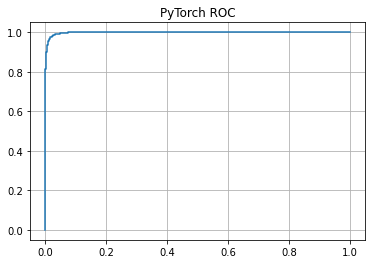

AUC score: 0.9981895309332429


In [12]:
fpr, tpr, _ = metrics.roc_curve(y_test, test_scores_np)
plt.plot(fpr, tpr)
plt.grid()
plt.title("PyTorch ROC")
plt.savefig("Pytorch_ROC.png")
plt.show()

print("AUC score:",  metrics.roc_auc_score(y_test, test_scores_np))

# Keras

In [13]:
batch_size = 256
epochs = 10

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_TMVA_SAMPLE_trained_model.h5'
    
model = Sequential()
model.add(Conv2D(6, (5, 5), data_format="channels_first"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
model.add(Conv2D(16, (5, 5), data_format="channels_first"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
model.add(Flatten())
model.add(Dense(120))
model.add(Activation('relu'))
model.add(Dense(84))
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))


model.build((None, 1, 32, 32))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 6, 28, 28)         156       
_________________________________________________________________
activation_1 (Activation)    (None, 6, 28, 28)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 14, 14)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 10, 10)        2416      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 10, 10)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 5, 5)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)              

In [14]:
# initiate SGD with momentum optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)

# Let's train the model
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [15]:
start=time.time()

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True)

train_time_keras = time.time() - start

print("Time taken to complete training: ", train_time_keras)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('\nSaved trained model at %s ' % model_path)

Epoch 1/10
16000/16000 [==============================] - 5s 299us/step - loss: 1.0000 - accuracy: 0.5217
Epoch 2/10
16000/16000 [==============================] - 5s 283us/step - loss: 0.6196 - accuracy: 0.6534
Epoch 3/10
16000/16000 [==============================] - 4s 265us/step - loss: 0.5521 - accuracy: 0.7102
Epoch 4/10
16000/16000 [==============================] - 4s 250us/step - loss: 0.4499 - accuracy: 0.7898
Epoch 5/10
16000/16000 [==============================] - 4s 246us/step - loss: 0.3385 - accuracy: 0.8499
Epoch 6/10
16000/16000 [==============================] - 4s 246us/step - loss: 0.3142 - accuracy: 0.8605
Epoch 7/10
16000/16000 [==============================] - 4s 245us/step - loss: 0.1966 - accuracy: 0.9201
Epoch 8/10
16000/16000 [==============================] - 4s 245us/step - loss: 0.2141 - accuracy: 0.9097
Epoch 9/10
16000/16000 [==============================] - 4s 257us/step - loss: 0.1710 - accuracy: 0.9300
Epoch 10/10
16000/16000 [=====================

In [16]:
# Score trained model.
keras_scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', keras_scores[0])
print('Test accuracy:', keras_scores[1])

4000/4000 [==============================] - 0s 105us/step
Test loss: 0.3437141745686531
Test accuracy: 0.859499990940094


## Evaluation & Training Time Keras

In [17]:
y_pred_keras = model.predict(X_test)
print(y_test)
print(y_pred_keras)

[[1.]
 [1.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]
[[4.4892851e-01]
 [7.1763247e-02]
 [4.3640760e-04]
 ...
 [6.8508210e-03]
 [9.8617002e-06]
 [5.0992963e-05]]


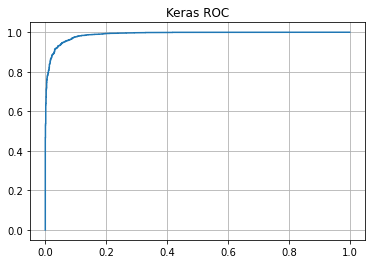

AUC score: 0.9888772791507773


In [18]:
fpr_keras, tpr_keras, _ = metrics.roc_curve(y_test, y_pred_keras)
plt.plot(fpr_keras, tpr_keras)
plt.grid()
plt.title("Keras ROC")
plt.savefig("Keras_ROC.png")
plt.show()

print("AUC score:",  metrics.roc_auc_score(y_test, y_pred_keras))

In [19]:
print("PyTorch Training Timein seconds:", train_time_pytorch)
print("Keras Training Time in seconds:", train_time_keras)

PyTorch Training Timein seconds: 46.95226311683655
Keras Training Time in seconds: 42.276041984558105


### Note: ROC Curve is plotted using the prediction scores (without any thresholding)